# CUBE LOVE DATA REDUCTION
This his how you make love to your cube in molecular hydrogen

let's start by uploading some useful libraries

In [48]:
#!/usr/bin/env python
import os,sys, math, string
import pyfits
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib import rc
from pylab import contour,cm,clabel
import aplpy

#to comment for python programs
get_ipython().magic(u'pylab inline')


Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


Let's specify the input directory and inputfile

    - rootdir = root directory where is the inputfile  
    - input_file

- outputdirectories:

    - root_cube=cubes.fits files
    - root_mask=masks.fits files
    - root_images=2dimages.fits files
    - root_figures= \*.pdf images


+ ** these need to exist already in your working directory **

In [49]:
rootdir='/Users/maccagni/Documents/PhD/PKS/data/'

input_file=rootdir+'combinOB13.fits'

root_cube=rootdir+'cubes/'
root_mask=rootdir+'masks/'
root_images=rootdir+'images/'
root_figures=rootdir+'figures/'

Define some important constants

- C, MSun, parsec [cm]
- wavelength of the line for velocity transformations
- systemic velocity of the galaxy


In [50]:
C=2.99792458E8 #cm/s
MSUN=1.98855e33 #g
PC=3.0857e18 #cm

#LAMBDAS
#s(1)
s1_0=2.12183e-6 #m
co=2.23282e-6 #m

#Systemic velocity
vel_sys=4394 #km/s

- Determine the wavelength range reading the header of the cube

In [51]:
f=pyfits.open(input_file)
in_f=f[0].data
headd=f[0].header
#set the spectral band
wave = (np.linspace(1,in_f.shape[0],in_f.shape[0])-headd['CRPIX3'])* headd['CDELT3'] + headd['CRVAL3']
# in frequency
wave_freq=np.array([])
wave_freq=C/(wave*1e-6)

Define functions of common use:
    
    - velocity conversion
    - polynomial subtraction median method
    - hanning
    - smoothing

In [52]:
def vel_vec(wave,s_line):
    vel=(C*(wave*1e-6-s_line)/s_line)*1e-3
    vel=vel-vel_sys
    
    return vel

def median_mine(copDat,z_giu_l,z_su_r,a_l,a_r,b_l,b_r):

    
    copDat_medsub = np.zeros([copDat.shape[0],copDat.shape[1],copDat.shape[2]])
    rig = np.zeros([copDat.shape[0]])
    
    copDat_down=copDat[a_l:a_r,:,:]
    copDat_up=copDat[b_l:b_r,:,:]
    
    x_down=a_l+((a_r-a_l)/2.)
    x_upp=b_l+((b_r-b_l)/2.)
    
    for j in xrange(x_low,x_up) :
        for i in xrange(y_low,y_up) :
            med_down= np.median(copDat_down[:,i,j])
            med_up= np.median(copDat_up[:,i,j])
          
            for k in xrange(z_giu_l,z_su_r):

                med_line=float(k-x_down)/float(x_upp-x_down)*(med_up-med_down)+med_down
                rig[k]=med_line
        
            copDat[z_giu_l:z_su_r,i,j] = -rig[z_giu_l:z_su_r] +copDat[z_giu_l:z_su_r,i,j]
 
    return copDat


def hanning_mine(inputt,delta_vel):
                
        func_y=np.hanning(delta_vel)
        func_y/=np.sum(func_y)
        
        for i in range(x_low,x_up) :
            for j in range(y_low,y_up) :     
                inputt[z_low:z_up,j,i]=np.convolve(inputt[z_low:z_up,j,i],func_y,mode='same') 
        
        return inputt

def convolution(inputt,sigma,z_l_low,z_l_up):
     
        mu=0.0
        x=np.linspace(-1,1,21)
        arg=-((x-mu)*(x-mu))/(2*sigma*sigma)
        gauss_ra=1./(np.sqrt(2*np.pi)*sigma)*np.exp(arg)       

 
        
        kernel = gauss_ra.reshape(21, 1) * gauss_ra.reshape(1, 21)               
        kernel /= kernel.sum()

        inputta=np.zeros([inputt.shape[0],inputt.shape[1],inputt.shape[2]])
        
        for k in xrange(z_l_low,z_l_up):
            inputta[k,:,:] = scipy.signal.convolve2d(inputt[k,:,:], kernel, mode='same')
        
        return inputta
    
def convolution2d(inputt,sigma):
        
        mu=0.0
        x=np.linspace(-1,1,21)
        arg=-((x-mu)*(x-mu))/(2*sigma*sigma)
        gauss_ra=1./(np.sqrt(2*np.pi)*sigma)*np.exp(arg)       
        
        kernel = gauss_ra.reshape(21, 1) * gauss_ra.reshape(1, 21)               
        kernel /= kernel.sum()
        
        inputt[:,:] = scipy.signal.convolve2d(inputt[:,:], kernel, mode='same')       
        
        return inputt

**Up to here to load always!!!!! **

*************************************************************

# Extract the spectrum from a chosen region

Define the input and output files:

    - final combined cube
    - filename output figure

In [91]:
in_file=input_file
outfile_fig=root_figures+'spectrum_centre_withcont.pdf'

Define important parameters:

    - edges of the field of view (pixel,pixel,channel)
    - edges of the region in channels
    - width of hanning in channels

In [92]:
#Spectral limits
z_low=100
z_up=2000

# EDGES of the Field of VIEW 
x_low=12
y_low=12

x_up=64
y_up=64

#*** CENTRE ***#
#average spectrum
x_l_s=38
x_r_s=41
y_d_s=39
y_u_s=41

delta_vel=9

Main to extract the spectrum

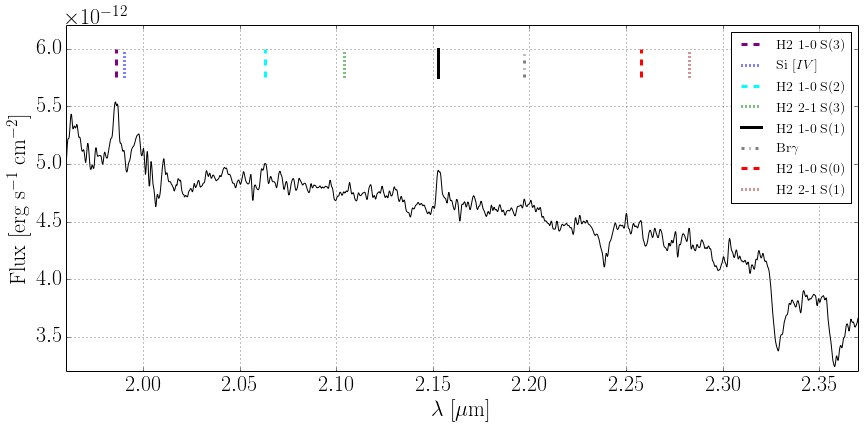

In [94]:
#MAIN to extract the spectrun

#open file
f=pyfits.open(in_file)
infiled=f[0].data
head=f[0].header


#hanning
infiled=hanning_mine(infiled,delta_vel)

spec_cool=np.zeros([infiled.shape[0]])

for i in xrange (0,infiled.shape[0]):
    spec_cool[i]=np.mean(infiled[i,y_d_s:y_u_s,x_l_s:x_r_s])

    
#convert from W/m^2 to erg s^-1 cm^-2: x1e7x1e-4
spec_cool=np.multiply(spec_cool,wave)
spec_cool=spec_cool*1e7

#PLOT

#uptload important parameters
fig = plt.figure(figsize=(14.2,6.2))

params = {'legend.fontsize': 14,
          'axes.linewidth':1,
           'legend.linewidth': 4,
           'xtick.labelsize':22,
           'ytick.labelsize':22,
           'text.usetex': True,
           'text.latex.unicode' : True }
rc('font',**{'family':'serif','serif':['serif']})


plt.rcParams.update(params)
a = fig.add_subplot(111, autoscalex_on=True,autoscaley_on=True)
plt.ylabel('Flux [erg s$^{-1}$ cm$^{-2}$]',fontsize=22)
plt.xlabel(r'$\lambda$ [$\mu$m]',fontsize=22)
a.set_xlim([1.960,2.37])
a.set_ylim([3.2*1e-12,6.2*1e-12])

#plot the spectrum
a.plot(wave[z_low:z_up],spec_cool[z_low:z_up],c='black',lw=1)

# draw detectable lines approximately where they should be
#S(3)
#S(3) line
z_3_low=220
z_3_up=248
s3_y=[5.75*1e-12,6.0*1e-12]
peak=np.argmax(spec_cool[z_3_low:z_3_up])
s3_x=[wave[z_3_low+peak],wave[z_3_low+peak]]
a.plot(s3_x,s3_y,lw=3,color='purple',label='H2 1-0 S(3)',ls='--')

#detected lines
#Si IV
siv_y=[5.75*1e-12,6.0*1e-12]
peak=np.argmax(spec_cool[z_3_up:z_3_up+10])
siv_x=[wave[z_3_up+peak],wave[z_3_up+peak]]
a.plot(siv_x,siv_y,lw=3,color='blue',label='Si $[\small IV]$',ls=':')

#S(2)
s0_l=520
s0_r=580
s3_y=[5.75*1e-12,6.0*1e-12]
peak=np.argmax(spec_cool[s0_l:s0_r])
s3_x=[wave[s0_l+peak],wave[s0_l+peak]]
a.plot(s3_x,s3_y,lw=3,color='cyan',label='H2 1-0 S(2)',ls='--')

#2-1S(3)
s0_l=700
s0_r=720
s3_y=[5.75*1e-12,6.0*1e-12]
peak=np.argmax(spec_cool[s0_l:s0_r])
s3_x=[wave[s0_l+peak],wave[s0_l+peak]]
a.plot(s3_x,s3_y,lw=3,color='green',label='H2 2-1 S(3)',ls=':')

#S(1)
#S(1) line
z_l_low=899
z_l_up=932
s1_y=[5.75*1e-12,6.0*1e-12]
peak=np.argmax(spec_cool[z_l_low:z_l_up])
s1_x=[wave[z_l_low+peak],wave[z_l_low+peak]]
a.plot(s1_x,s1_y,lw=3,color='black',label='H2 1-0 S(1)',ls='-')

#brgamma
br_l=1078
br_r=1111

s1_y=[5.75*1e-12,6.0*1e-12]
peak=np.argmax(spec_cool[br_l:br_r])
s1_x=[wave[br_l+peak],wave[br_l+peak]]
a.plot(s1_x,s1_y,lw=3,color='grey',label='Br$\gamma$',ls='-.')


#S(0)
s0_l=1340
s0_r=1370

s1_y=[5.75*1e-12,6.0*1e-12]
peak=np.argmax(spec_cool[s0_l:s0_r])
s1_x=[wave[s0_l+peak],wave[s0_l+peak]]
a.plot(s1_x,s1_y,lw=3,color='red',label='H2 1-0 S(0)',ls='--')

#2-1S(1)
s0_l=1420
s0_r=1448

s1_y=[5.75*1e-12,6.0*1e-12]
peak=np.argmax(spec_cool[s0_l:s0_r])
s1_x=[wave[s0_l+peak],wave[s0_l+peak]]
a.plot(s1_x,s1_y,lw=3,color='brown',label='H2 2-1 S(1)',ls=':')

#plot fancy things
plt.legend()
plt.grid()

fig.savefig(outfile_fig)



# Stellar continuum subtraction

Define the main parameters:

- Output file names

  - Cubes
     - stellar continuum : out_stars
     - continuum subtracted: out_starsub
     - smoothed median subtrated : out_nh
     - hanned median subtracted : out_h
     - mask for the line emission regions : mask_file
     

In [284]:
out_starsub=root_cube+'starsub.fits'
out_stars=root_cube+'stars.fits'

out_nh=root_cube+'nh.fits'
out_h=root_cube+'h.fits'

mask_file=root_mask+'H2_mask.fits'


- Constants
    
    - Edges of the cube
    - Cutoff values
    - Hanning number of channels
    - Convolution beam in arcsecons : cube and masks


In [285]:
#Spectral limits
z_low=100
z_up=2000

# EDGES of the Field of VIEW 
x_low=12
y_low=12

x_up=64
y_up=64

#cutoff value for the mask 
value=3

#hanning width
delta_vel=7 # number of channels

#spatial convolution gaussian
sigma=300./3600.  #in degrees #parameter for the emission cubes
sigma_masch=200./3600.  #in degrees   #parameter for the mask


- Functions

  - stellar subtraction

  - median subtraction

  - hanning

  - convolution
  
  - median edges definition
  
  - making masks

In [286]:
def stellar_template(masDat,copDat,data):

    avSpec_left = np.zeros(zlen)
    spec_cont=np.zeros([zlen,ylen,xlen]) 
    numSpecs_left = 0.0

    for i in range(x_low,x_up) :
        for j in range(y_low,y_up) :
            if (masDat[j,i] <= 0.01) :
                spec = data[:,j,i]
                s = spec[z_low:z_up].sum()
                avSpec_left[z_low:z_up] = avSpec_left[z_low:z_up]+spec[z_low:z_up]*s*s
                numSpecs_left += s*s
    
    avSpec_left = avSpec_left/numSpecs_left
    
    for i in range(x_low,x_up) :
        for j in range(y_low,y_up) :
            spec = data[:,j,i]
            s = spec[z_low:z_up].sum()
            ss = avSpec_left[z_low:z_up].sum()
            copDat[z_low:z_up,j,i] = data[z_low:z_up,j,i] - avSpec_left[z_low:z_up]*s/ss
            spec_cont[z_low:z_up,j,i]=avSpec_left[z_low:z_up]*s/ss

            
    #writing outputs        

    pyfits.writeto(out_starsub, copDat[:,:,:], head.copy(), clobber = True)    
    pyfits.writeto(out_starsub, spec_cont[:,:,:], head.copy(), clobber = True)            
            
    return copDat,avSpec_left


def subfirst(copDat,masDat,data):


    stellar_template(masDat,copDat,data)


    #median method : S(3) line

    z_giu_l3=z_low
    z_su_r3=600

    a_l=120
    a_r=210
    b_l=250
    b_r=400
    
    copDat=median_mine(copDat,z_giu_l3,z_su_r3,a_l,a_r,b_l,b_r)

    #median method : S(1) line
    
    z_giu_l1=z_su_r3
    z_su_r1=1040

    a_l=z_su_r3
    a_r=895
    b_l=932
    b_r=z_su_r1
    copDat=median_mine(copDat,z_giu_l1,z_su_r1,a_l,a_r,b_l,b_r)

    
    #median method : other  line 

    z_giu_br=z_su_r1
    z_su_br=1260

    a_l=z_su_r1
    a_r=1084
    b_l=1100
    b_r=z_su_br 
     
    copDat=median_mine(copDat,z_giu_br,z_su_br,a_l,a_r,b_l,b_r)
    
    
    #median method around the other lines

    z_giu_o=z_su_br
    z_su_o=z_up

    a_l=z_su_br
    a_r=1300
    b_l=1536
    b_r=1860 
     
    copDat=median_mine(copDat,z_giu_o,z_su_o,a_l,a_r,b_l,b_r)
    
    #convolution

    copDat=convolution(copDat,sigma,z_low,z_up) 
    pyfits.writeto(out_nh, copDat[:,:,:], head.copy(), clobber = True)

    #hanning
  
    copDat=hanning_mine(copDat,delta_vel)   
    pyfits.writeto(out_h, copDat[:,:,:], head.copy(), clobber = True)


    return copDat

def maskk(infiled,value):
    
    #S(1) line # because I mask where there is NO H2 1-0 S(1) line emission
    z_l_low=899
    z_l_up=932
    
    #edges for the noise estimation needed to set the cutoff
    x_nl=16
    x_nr=36
    y_nd=50
    y_nu=60
    
    #make the mask
    mask=np.zeros([infiled.shape[0],infiled.shape[1],infiled.shape[2]])
    mask2d=np.zeros([infiled.shape[1],infiled.shape[2]])
    n=0
    for k in xrange (z_l_low,z_l_up):
        noise=np.std(infiled[k,y_nd:y_nu,x_nl:x_nr])
        values=value*noise/1.
        n+=1
        for j in xrange (y_low,y_up):
            for i in xrange (x_low,x_up):
                if infiled[k,j,i]>values:
                    mask[k,j,i]=1.
                else:
                    mask[k,j,i]=0.0
        mask2d+=mask[k,:,:]
     
    mask_smooth2d=np.zeros([infiled.shape[1],infiled.shape[2]])
    mask_smooth2d=convolution2d(mask2d,sigma_masch)
    
    
    return mask_smooth2d

MAIN of the stellar continuum pipeline

In [287]:
##### MAIN MAIN MAIN

print '*********************'
print 'Start preparing cubes'

f=pyfits.open(input_file)
head=f[0].header
data=f[0].data

mas = pyfits.open(mask_file)
masDat = mas[0].data

xlen = data.shape[2]
ylen = data.shape[1]
zlen = data.shape[0]

#set some arrays
spec_medio= np.zeros(zlen)
copDat = np.zeros([zlen,ylen,xlen])
copCont = np.zeros([zlen,ylen,xlen])

#set the spectral band
#wave = (np.linspace(1,data.shape[0],data.shape[0])-head['CRPIX3'])* head['CDELT3'] + head['CRVAL3']
# in frequency
#wave_freq=np.array([])
#wave_freq=C/(wave*1e-6)

#iterative masking and continuum subtracting
copDat=subfirst(copDat,masDat,data)



masDat_new2d=maskk(copDat,value)

copDat = np.zeros([zlen,ylen,xlen])
copDat=subfirst(copDat,masDat_new2d,data)

print 'END of preparing cubes'
print '*********************\n'


*********************
Start preparing cubes
END of preparing cubes
*********************



# Moment maps production

Produce Intensity and Velocity field of the H2 1-0 S(1) line


** Moment 0 maps are produced in RELATIVE FLUX [ x 10^12 erg s^-1 cm^-2] **

** Moment 1 maps are in km s^-1 relative to the systemic velocity = vel_sys in fundamental parameters **

SINFONI input maps: W m^-2

Conversion to erg s^-1 cm^-2: x 10^7 x 10^-4


*****************


Define the main parameters:

-Input files
    
    - final data cube = out_nh in "Stellar continuum subtraction" 
    
    - cube of the stellar continuum = out_stars in "Stellar continuum subtraction"
    
    - hanned final data cube = out_h - to create the masks for the moment 0 and 1 maps
    



In [43]:
in_nh=root_cube+'nh.fits'       #final data cube
in_stars=root_cube+'stars.fits' #same as out_stars in stellar continuum
in_h=root_cube+'h.fits'         #hanned final data cube

 - Output file names
   - name of the line
   - Cubes
   - Images
   - Figures

In [44]:
linename='s1'

#cubes
out_int_cu=root_cube+'int_cube_'+linename+'.fits'

#images
out_int_im=root_images+'int_im_'+linename+'.fits'
out_vel_im=root_images+'vel_im_'+linename+'.fits'

#figures
out_int_fig=root_figures+'int_'+linename+'.pdf'
out_vel_fig=root_figures+'vel_'+linename+'.pdf'

#masks
out_vel_mask=root_mask+'vel_mask_'+linename+'.fits'


- Constants
    - location of the line in channels (edges of the integration) and edges of the field of view
    - edges of the field of view, to estimate the noise, and to build the moment maps
    - parameters to smooth the cube and the masks for moment 0 and 1 maps and the mask
    - signal cutoff to produce the maps (in rms noise)
    - sigma contour leves for plotting
    - direction of the continuum of the radio jets 
        - array extension in x,y pixel coordinates
        - position angle

In [59]:
#S(1) line
z_l_low=901
z_l_up=930
# EDGES of the Field of VIEW 
x_low=12
y_low=12

x_up=64
y_up=64

#edges for the noise estimation within the field of view in channels
x_nl=16
x_nr=36
y_nd=50
y_nu=60

z_l=899
z_u=932

#spatial convolution gaussian
sigma_vel=350./3600.  #in degrees
sigma_int=320./3600.  #in degrees
sigma_masch=390./3600.  #in degrees

#rms noise cutoff 
value_vel=2.5
val_int=2.2

#sigma values on the noise for the contours
val_sig_int=[1.6,3,5,7,9,12]

#direction of the continuum of the radio jets
x_mid=41
y_mid=39
x_loww=36.5
x_upp=45.5
pa_cont_ALL=42 

In [60]:
def intensity(infiled,mask,wave):

    print 'INTENSITY'

    intens=np.zeros([infiled.shape[1],infiled.shape[2]])
    intensnew=np.zeros([infiled.shape[1],infiled.shape[2]])
   

    diff=0.0 
    noise_int=0.0
    n=0.0
    for k in xrange(z_l,z_u):
        noise_int+=(np.std(infiled[k,y_nd:y_nu,x_nl:x_nr]))*(np.std(infiled[k,y_nd:y_nu,x_nl:x_nr]))
        diff+=wave[k+1]-wave[k]
        n+=1.
        for j in xrange(y_low,y_up):
            for i in xrange(x_low,x_up):             
                if mask[k,j,i]>=0.001:
                    intens[j,i]=intens[j,i]+infiled[k,j,i]

    
    ##set the right units:
    # from W/m^2 * 1e7*1e-4 = erg/s cm^-2  * 1e8 to normalize
    
    diff_av=abs(diff/n)
    intens=np.multiply(intens,diff_av)
 
    noise_int=np.sqrt(noise_int)*diff_av
    val_int=np.multiply(val_sig_int,noise_int)

    for k in xrange(z_l_low,z_l_up): 
        for j in xrange(y_low,y_up):
            for i in xrange(x_low,x_up):     
                if  intens[j,i]>=val_int[0]:
                    intensnew[j,i]=intens[j,i]
 

    intens=intensnew*1e7/1e-16
    val_int=val_int*1e7/1e-16
    

    #write output image .figs
    pyfits.writeto(out_int_im,intens, head.copy(), clobber = True) 
    #write output cube .figs
    pyfits.writeto(out_int_cu,infiled[z_l:z_u,:,:], head.copy(), clobber = True) 
 


    #determine the direction of the radio jets of the continuum
    x3=np.linspace(x_loww,x_upp,100)
    m=np.tan(math.radians(pa_cont_ALL))
    y3=m*(x3-x_mid)+y_mid
    
    
    ##MAKE PLOT .pdf
    #PLOT

    #open HANNED cube for aplpy
    #f=pyfits.open(in_h)
    #headd=f[0].header

    #set initial parameters of the plot
    f = plt.figure(figsize=(8,8))
    params = {'legend.fontsize': 14,
           'axes.linewidth':1,
           'lines.linewidth':5,
           'legend.linewidth': 4,
           'xtick.labelsize':20,
           'ytick.labelsize':20,
           'xlabel.fontsize':20,
           'ylabel.fontsize':20,
           'text.usetex': True,
           'text.latex.unicode' : True }
    rc('font',**{'family':'serif','serif':['serif']})

    plt.rcParams.update(params)

    f = aplpy.FITSFigure(in_nh,dimensions=[0,1],slices=[0],tight_layout=True)
    f.add_grid()
    f.recenter(float(headd['CRVAL1'])+0.00027,float(headd['CRVAL2'])-0.00007,width=math.radians(6.1/60.),
               height=math.radians(6.2/60.))
    
    f.axis_labels.set_font(size=20,weight=300, \
                         stretch='ultra-condensed',\
                         style='normal', variant='normal')
    
    f.ticks.set_xspacing(0.0015)  # degrees
    f.tick_labels.set_font(size=20,weight=300, \
                         style='normal',stretch='ultra-condensed')


    #plot the direction of the radio jets
    plt.plot(x3,y3,color='green',lw=4,ls='--')
    
    #plot the moment zero map
    im = plt.imshow(intens[x_low:x_up,y_low:y_up], cmap='gist_heat_r',origin='lower',interpolation='spline36',
                    vmin=np.min(intens[x_low:x_up,y_low:y_up]),
                    vmax=np.max(intens[x_low:x_up,y_low:y_up]),
                    extent=(x_low,x_up,y_low,y_up))
    #and its contours                   
    cset = contour(intens[x_low:x_up,y_low:y_up],val_int,origin='lower',colors='gray',linewidths=1,ls=':',
                   extent=(x_low,x_up,y_low,y_up))
    
    #plot contours of isophotes
    
    #open stars cube to plot the isophotes
    f=pyfits.open(in_stars)
    
    #determine noise of the cube for contour levels
    stars=f[0].data 
    stars_image=np.zeros([ylen,xlen])
    mean_value=0.0
    
    for i in xrange(700,750):
        stars_image+=stars[i,:,:]
        mean_value+=np.std(stars[i,51:61,15:34])
        
    #set contour levels
    value=[mean_value,5.*mean_value,7.*mean_value,9.*mean_value,15.*mean_value]
    #plot contours
    cset = contour(stars_image[x_low:x_up,y_low:y_up],value,origin='lower',colors='black',linewidths=1,ls=':',
                   extent=(x_low,x_up,y_low,y_up))

    
    cbar=plt.colorbar(im,spacing='uniform')
    cbar.ax.tick_params(direction='out')
    cbar.ax.get_yaxis().labelpad = 2
    cbar.ax.tick_params(labelsize=20) 
    cbar.ax.set_ylabel(r'Relative Intensity', rotation=90,fontsize=20)
    
  
    #save the image
    f=plt.savefig(out_int_fig,clobber='yes')
    
    
    return val_int

def velocity(infiled,mask,vel,val):
    
    print 'VELOCITY'

    #define vectors for integral
    velox=np.zeros([infiled.shape[1],infiled.shape[2]])
    velox_sum=np.zeros([infiled.shape[1],infiled.shape[2]])
    veloc=np.zeros([infiled.shape[0],infiled.shape[1],infiled.shape[2]])

    #determine the moment 1 map
    print val
    diff=0.0
    for k in xrange(z_l,z_u):
        diff=vel[k+1]-vel[k]
        noise=np.std(infiled[k,y_nd:y_nu,x_nl:x_nr])
        values=val_vel[0]*noise     
        for j in xrange(y_low,y_up):
            for i in xrange(x_low,x_up):     
                if  mask[j,i]>=val[0] and infiled[k,j,i]>=values:
                    velox[j,i]=velox[j,i]+infiled[k,j,i]*vel[k]*diff
                    velox_sum[j,i]=velox_sum[j,i]+infiled[k,j,i]*diff
                    veloc[k,j,i]=infiled[k,j,i]*vel[k]*diff
                    

    # setright units
    velox_tot=np.divide(velox,velox_sum)

    #relative to the systemic velocity
    velox_tot=velox_tot-vel_sys

    #determine the direction of the radio jets
    x3=np.linspace(x_loww,x_upp,100)
    m=np.tan(math.radians(pa_cont_ALL))
    y3=m*(x3-x_mid)+y_mid
    
    ## Make Plot .pdf
    #PLOT

    #set the right parameters for the plot
    ff = plt.figure(figsize=(8,8))
    params = {'legend.fontsize': 14,
           'axes.linewidth':1,
           'lines.linewidth':5,
           'legend.linewidth': 4,
           'xtick.labelsize':20,
           'ytick.labelsize':20,
           'xlabel.fontsize':20,
           'ylabel.fontsize':20,
           'text.usetex': True,
           'text.latex.unicode' : True }
    rc('font',**{'family':'serif','serif':['serif']})

    plt.rcParams.update(params)


    f = aplpy.FITSFigure(in_nh,dimensions=[0,1],slices=[0],tight_layout=True)
    f.add_grid()
    f.recenter(float(headd['CRVAL1'])+0.00027,float(headd['CRVAL2'])-0.00007,width=math.radians(6.1/60.),height=math.radians(6.2/60.))

    f.axis_labels.set_font(size=20, weight=300, \
                         stretch='ultra-condensed',\
                         style='normal', variant='normal')
    
    f.ticks.set_xspacing(0.0015)  # degrees
    f.tick_labels.set_font(size=20, weight=300, \
                         style='normal',stretch='ultra-condensed')
    
    #plot the direction of the radio jet
    plt.plot(x3,y3,color='black',lw=4,ls='--')
    
    #plot the moment 1 map
    im = plt.imshow(velox_tot[x_low:x_up,y_low:y_up], cmap='nipy_spectral',interpolation='spline36',origin='lower'
                    ,vmin=-300,vmax=300,extent=(x_low,x_up,y_low,y_up))

    
    # plot the colors
    cbar=plt.colorbar(im) 
    cbar.ax.get_yaxis().labelpad = - 10
    cbar.ax.tick_params(labelsize=18) 
    cbar.ax.set_ylabel(r'km s$^{-1}$', rotation=90,fontsize=20)
    
    #draw intensity contours
    cset = contour(mask[x_low:x_up,y_low:y_up],val,origin='lower',colors='black',linewidths=1,ls=':',extent=(x_low,x_up,y_low,y_up))
    
    #save the figure
    ff=plt.savefig(out_vel_fig)
    
    #write output image
    pyfits.writeto(out_vel_im,velox_tot, head.copy(), clobber = True)     
    
    #write output mask 
    pyfits.writeto(out_vel_mask,mask, head.copy(), clobber = True)  

    return velox_tot

def mask_int(infiled,value):

    def convolution(inputt,sigma):
     
        mu=0.0
        x=np.linspace(-1,1,21)
        arg=-((x-mu)*(x-mu))/(2*sigma*sigma)
        gauss_ra=1./(np.sqrt(2*np.pi)*sigma)*np.exp(arg)       

 
        
        kernel = gauss_ra.reshape(21, 1) * gauss_ra.reshape(1, 21)               
        kernel /= kernel.sum()

        inputta=np.zeros([inputt.shape[0],inputt.shape[1],inputt.shape[2]])
        
        for k in xrange(z_l_low,z_l_up):
            inputta[k,:,:] = scipy.signal.convolve2d(inputt[k,:,:], kernel, mode='same')
        
        return inputta
    
    #S(1) line # because I mask where there is NO H2 1-0 S(1) line emission
    z_l=899
    z_up=932
    
    #edges for the noise estimation needed to set the cutoff
    
    #make the mask
    mask=np.zeros([infiled.shape[0],infiled.shape[1],infiled.shape[2]])
    n=0
    for k in xrange (z_l,z_u):
        noise=np.std(infiled[k,y_nd:y_nu,x_nl:x_nr])
        values=value*noise/1.
        n+=1
        for j in xrange (y_low,y_up):
            for i in xrange (x_low,x_up):
                if infiled[k,j,i]>values:
                    mask[k,j,i]=1.
                else:
                    mask[k,j,i]=0.0
     
    mask_smooth=np.zeros([infiled.shape[0],infiled.shape[1],infiled.shape[2]])
    mask_smooth=convolution(mask,sigma_masch)
    
    
    return mask_smooth


MAIN of the moment maps production

Populating the interactive namespace from numpy and matplotlib
INTENSITY
VELOCITY
[ 0.51274594  0.96139864  1.60233107  2.24326349  2.88419592  3.84559456]

`%matplotlib` prevents importing * from pylab and numpy
/Library/Python/2.7/site-packages/ipykernel/__main__.py:160: RuntimeWarning: invalid value encountered in divide



NORMAL TERMINATION


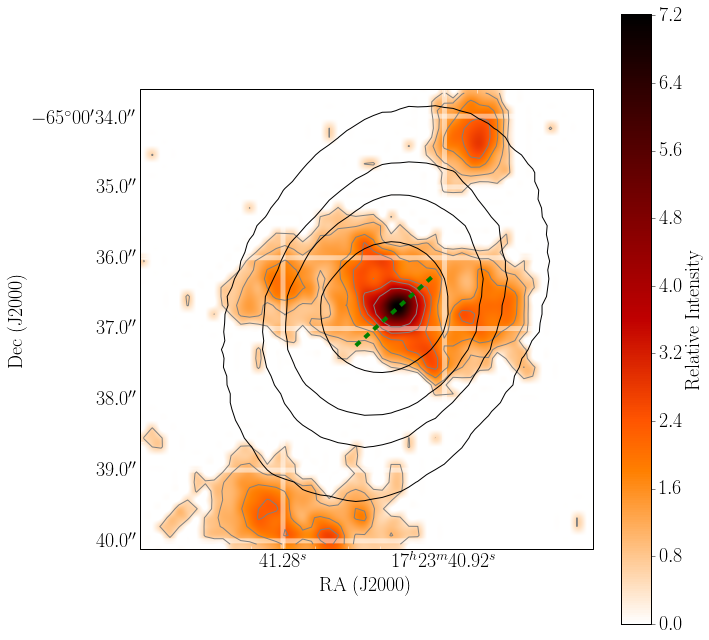

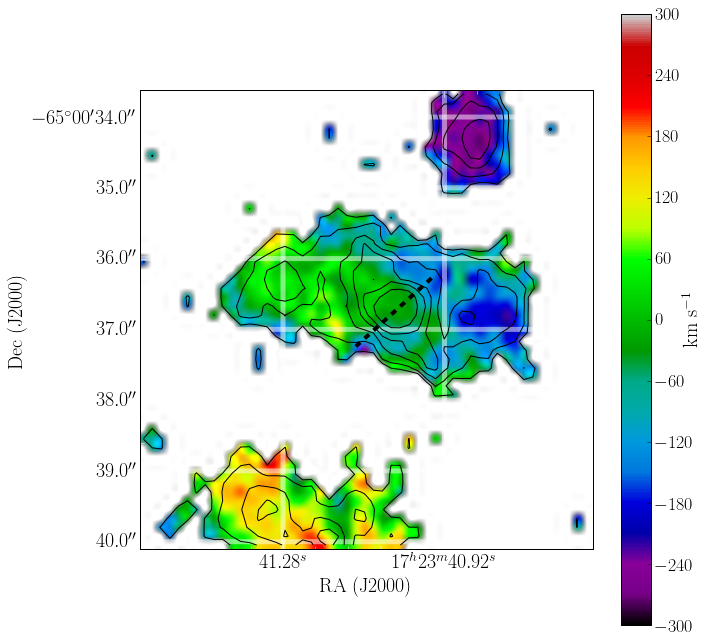

In [61]:
## MAIN for moment map production
get_ipython().magic(u'pylab inline')

#intensity
#make a mask using the hanned cube
f=pyfits.open(in_nh)
in_m=f[0].data
headd=f[0].header
mask=mask_int(in_m,value_vel)
#open final cube cube
f=pyfits.open(in_nh)
infile=f[0].data
head=f[0].header
val_vel=intensity(infile,mask,wave)


#velocity
#open the intensity map to use as a mask
f=pyfits.open(out_int_im)
infiled=f[0].data

#determine the velocity of the line in km/s
vel_s1=(C*(wave*1e-6-s1_0)/s1_0)*1e-3 #!!!!!!!!!
#vel_s1=vel_vec(wave,s1_0)

cassa=velocity(infile,infiled,vel_s1,val_vel)

print 'NORMAL TERMINATION'

*****************************************
# Analysis of the centre

    - spectrum in 3 adjacent regions
    - position velocity diagram along the major axis of the inner disk
    
** Spectrum **

Define input and output files:

    - Input: final cube
    - Filename output figure

In [293]:
in_file=rootdir+'combinOB13.fits'
out_fig_spec=root_figures+'spectrum_centre_regions.pdf'

Define the regions where to extract the spectrum:

    - location of the line in channels
    - regions in pixels
        - centre
        - left
        - right
    
- hanning of the cube in channels

In [294]:
#S(1) line
z_l_low=899
z_l_up=932

#centre
x_mid=41
y_mid=39
#left
x_LL=37
x_LR=39
#right
x_RR=42
x_RL=44
#hanning
delta_vel=7

MAIN to extract and plot the spectrum

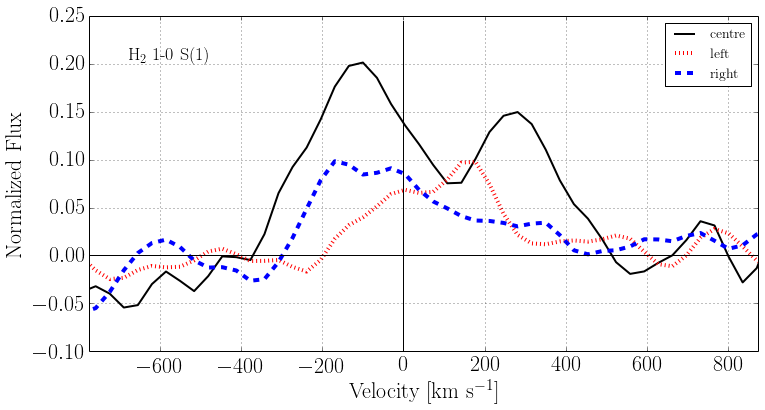

In [295]:
#SPECTRUM

#load input file
f=pyfits.open(in_file)
head=f[0].header
datat=f[0].data

#hanning 
datat=hanning_mine(datat,delta_vel)

vel_s1=vel_vec(wave,s1_0)

z_l_low=z_l_low-100
z_l_up=z_l_up+100

specsum_l = np.zeros([datat.shape[0]])
specsum_r = np.zeros([datat.shape[0]])
n=0.
for i in xrange(37,39):
    specsum_l[z_l_low:z_l_up]+=datat[z_l_low:z_l_up,39,i]
    n+=1.
    
specsum_l/=n

n=0.
for i in xrange(42,44):
    specsum_r[z_l_low:z_l_up]+=datat[z_l_low:z_l_up,39,i]
    n+=1.    
specsum_r/=n

#straighten the spectrum
datat[z_l_low:z_l_up,y_mid,x_mid]=datat[z_l_low:z_l_up,y_mid,x_mid]-np.median(datat[z_l_low:z_l_up,y_mid,x_mid])
specsum_l[z_l_low:z_l_up]=specsum_l[z_l_low:z_l_up]-np.median(specsum_l[z_l_low:z_l_up])
specsum_r[z_l_low:z_l_up]=specsum_r[z_l_low:z_l_up]-np.median(specsum_r[z_l_low:z_l_up])


#convert everything to the normalized units

#regions left and right
specsum_l=np.divide(specsum_l,wave_freq)
specsum_l=specsum_l*1e7*1e23*1e3
specsum_r=np.divide(specsum_r,wave_freq)
specsum_r=specsum_r*1e7*1e23*1e3

#centre
vec=np.array(datat[:,y_mid,x_mid])
datal=np.divide(vec,wave_freq)
datal=datal*1e7*1e23*1e3

#shift to the systemic velocity
diff=0.0
n=0.0
for i in xrange (z_l_low+100,z_l_up-100):
    diff+=vel_s1[i+1]-vel_s1[i]
    n+=1.



fig = plt.figure(figsize=(12,6))
params = {'legend.fontsize': 14,
           'axes.linewidth':1,
           'lines.linewidth':5,
           'legend.linewidth': 4,
           'xtick.labelsize':22,
           'ytick.labelsize':22,
           'xlabel.fontsize':22,
           'ylabel.fontsize':22,
           'text.usetex': True,
           'text.latex.unicode' : True }
rc('font',**{'family':'serif','serif':['serif']})

plt.rcParams.update(params)

a = fig.add_subplot(111, autoscalex_on=True,autoscaley_on=True)
#a.set_xticks(diffvec,minor=True)
#a.xaxis.grid(True, which='minor')
a.plot(vel_s1[z_l_low:z_l_up],datal[z_l_low:z_l_up],c='black',lw=2,label='centre')
a.plot(vel_s1[z_l_low:z_l_up],specsum_l[z_l_low:z_l_up],c='red',lw=4,label='left',ls=':')
a.plot(vel_s1[z_l_low:z_l_up],specsum_r[z_l_low:z_l_up],c='blue',lw=4,label='right',ls='--')
a.set_xlim([-774,874])
a.set_ylim([-0.1,0.25])
plt.ylabel('Normalized Flux',fontsize=22)
plt.xlabel(r'Velocity [km s$^{-1}$]',fontsize=22)

#o line
c=[-774,874]
d=[0,0]
a.plot(c,d,lw=1,c='black')


#o line
c=[-0.1,0.245]
d=[0,0]
a.plot(d,c,lw=1,c='black')


#plot fancy stuff
a.annotate(r'H$_2$ 1-0 S(1)', xy=(0.12, 0.85), xycoords='axes fraction', fontsize=18,
                horizontalalignment='center', verticalalignment='bottom')

plt.legend()
plt.grid()
plt.show()

fig.savefig(root_figures+'spectrum_cont.pdf',bbox_inches='tight')

** Position Velocity Diagram **

Define input and output files:

    - Input: final hanned cube
    - Output: Filename output figure
              Filename output fitsfile (which can be an input only for plotting)

In [296]:
in_file=root_cube+'h.fits'
out_pv=root_images+'pv_plot.fits'
#out_pv=root_images+'pv_plot_s1_40.fits'
out_pv_fig=root_figures+'pv_plot.pdf'

Define important parameters:
    
    - location of the line in channels
    - region of the field of view where to make the cut
    - size of pixel in parsec for header of fitsfile

In [297]:
#S(1) line
z_l_low=899
z_l_up=932

#region
x_l_s=39-20
x_r_s=42+20
y_mid=40

#pixel size
#1 pixel = 0.125 arcseconds= 36.8194 pc
c_delt1 =36.8194

In [299]:
#MAIN PV-PLOT
#H2
file=root_cube+'h.fits'
f=pyfits.open(in_file)
infiled=f[0].data
headd=f[0].header

wave = (np.linspace(1,infiled.shape[0],infiled.shape[0])-headd['CRPIX3'])* headd['CDELT3'] + headd['CRVAL3']

#Extract pv-plot image and save it
x_l_s=39-20
x_r_s=42+20
y_mid=40

xdim= x_r_s-x_l_s
vel=vel_vec(wave,s1_0)
xmid=(x_r_s-x_l_s)/2.
zdim=z_l_up-z_l_low

#1 pixel = 0.125 arcseconds= 36.8194 pc

#xdim_pc=xdim*36.8194

diff=0.
n=0.
i=0.0
for i in xrange(z_l_low,z_l_up):
    diff+=vel[i+1]-vel[i]
    n+=1.

diff=diff/n

#pv plot header
pv = pyfits.PrimaryHDU()
head_pv=pv.header
head_pv.set('NAXIS',2,after='BITPIX')
head_pv.set('NAXIS1',xdim,after='NAXIS')
head_pv.set('NAXIS2',zdim,after='NAXIS1')
head_pv.set('CTYPE1','Offset [pc]',after='NAXIS2')
head_pv.set('CRPIX1',xmid+0.5,after='CTYPE1')
head_pv.set('CRVAL1',0.0,after='CRPIX1')
head_pv.set('CDELT1',36.8194,after='CRVAL1')
head_pv.set('CTYPE2','VEL-OPT',after='CDELT1')
head_pv.set('CRPIX2',1,after='CTYPE2')
head_pv.set('CRVAL2',vel[z_l_low],after='CRPIX2')
head_pv.set('CDELT2',diff,after='CRVAL2')

#s(1)
pv_plot=infiled[z_l_low:z_l_up-1,y_mid,x_l_s:x_r_s-1]
pv_plot=convolution2d(pv_plot,300./3600.)

#output file
pyfits.writeto(out_pv,pv_plot, head_pv.copy(), clobber = True)     

print 'NORMAL TERMINATION'


NORMAL TERMINATION


Plot the Position Velocity diagram

    - define edges for the noise estimation
    - define contour values in units of sigma

In [300]:
#estimate the noise for the contours
x_l_sn=25
x_r_sn=42
z_l_downn=20
z_l_upn=32

#countours
val_sig_neg=[-1.5,-2.5]
val_sig=[2,3,5,7,9,12]


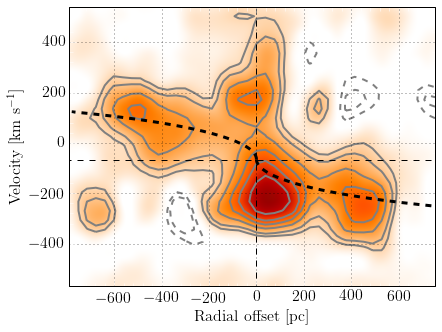

In [301]:
#PLOT

#define the function of the Hernquist profile
def  HernVel(radius, mass, effRadius) :
    
    MASS_CONST  = 2.31 * 10**5
    scaledRadius = effRadius / 1.8153
    retValue=np.zeros([len(radius)])

    for i in xrange (len(radius)):
        retValue[i] = math.sqrt(mass * radius[i]/MASS_CONST)
        retValue[i] = retValue[i] / (radius[i] + scaledRadius)
   
    return retValue

f=pyfits.open(out_pv)
pv_plot=f[0].data
headd=f[0].header


#set the parameters of the plot
params = {'legend.fontsize': 14,
           'axes.linewidth':1,
           'lines.linewidth':5,
           'legend.linewidth': 4,
           'xticks.labelsize':1,
           'xtick.labelsize':16,
           'ytick.labelsize':16,
           'xlabel.fontsize':16,
           'ylabel.fontsize':16,
           'text.usetex': True,
           'text.latex.unicode' : True }

#from matplotlib import rc
rc('font',**{'family':'serif','serif':['serif']})


plt.rcParams.update(params)


#plot figure

fig = aplpy.FITSFigure(out_pv,figsize=(8,5))
#fig.set_theme('publication')


#draw pvplot
im=plt.imshow(pv_plot, cmap='gist_heat_r',origin='lower',interpolation='spline36',vmin=0.027e-21,vmax=3.20e-20,
              extent=[0,43,-1,33])


#Positive and negative contours



pv_plot_noise=pv_plot[z_l_downn:z_l_upn,x_l_sn:x_r_sn]
noise_pv=np.std(pv_plot_noise)*1.1
val_pv=np.multiply(val_sig,noise_pv)
noise_pv=np.std(pv_plot_noise)/1.3

val_pv_neg=np.multiply(val_sig_neg,noise_pv)

#plot contours
cset = contour(pv_plot,val_pv,linewidths=2,origin='lower',colors='gray',extent=[0,43,-1,33])
cset = contour(pv_plot,val_pv_neg,linewidths=2,origin='lower',colors='gray',ls='--',extent=[0,43,-1,33])


##Hernquist profile

effRadius=pow(10,0.99) #kpc
mass=4e11
radius=np.linspace(0,.780,2000) #from 0 to .700 kpc = the maximum radius of the inner H2 disk 

vel_hern=HernVel(radius,mass,effRadius)

#radius in pc for plotting
radius=radius*1e3
radius_neg=np.array(-radius)

radius=radius/36.8194+22.0
radius_neg=radius_neg/36.8194+22.0


#negative velocities since it is a symmetric profile
vel_hern_neg=np.array(-vel_hern)
vel_hern=vel_hern/float(headd['CDELT2'])+15.
vel_hern_neg=vel_hern_neg/float(headd['CDELT2'])+15.

a=[22.0,22.0]
b=[0,54]
cc=[14.9,14.9]
plt.plot(a,b,c='black',lw=1,ls='--')
plt.plot(b,cc,c='black',lw=1,ls='--')

# plot hernquist profile
plt.plot(radius,vel_hern_neg,marker=' ',lw=3, label='Hernquist profile',color='black',ls='--')
plt.plot(radius_neg,vel_hern,marker=' ',lw=3, color='black',ls='--')

#labels
plt.ylabel(r'Velocity [km s$^{-1}$]',fontsize=16)
plt.xlabel(r'Radial offset [pc]',fontsize=16)
plt.grid()


#SAVE
plt.savefig(out_pv_fig,bbox_inches='tight')




**********
# Further graphycal checks

** Rotation of the stellar component: extracting spectra in the North, South and Centre of the field of view **

Define the main parameters:

    - Input: final data cube
    - Output: filename of figure
    - Regions
    - Edges for polynomial subtraction (median method)
    - hanning width in channels
    - location of the stellar line

In [71]:
in_file=rootdir+'combinOB13.fits'
out_fig_stars=root_figures+'spectrum_stars.pdf'

#North
x_lN=50
x_rN=53
y_dN=57
y_uN=60   

#South
x_lS=24
x_rS=27
y_dS=15
y_uS=18    

#Centre
x_lC=40
x_rC=42
y_dC=39
y_uC=41

#sky edges for polynomial subtraction
x_low=12
y_low=12

x_up=64
y_up=64

z_low=100
z_up=2000

#hanning
delta_vel=9.

#stellar line location
z_low_star=1600
z_up_star=1900

MAIN of the further graphical checks

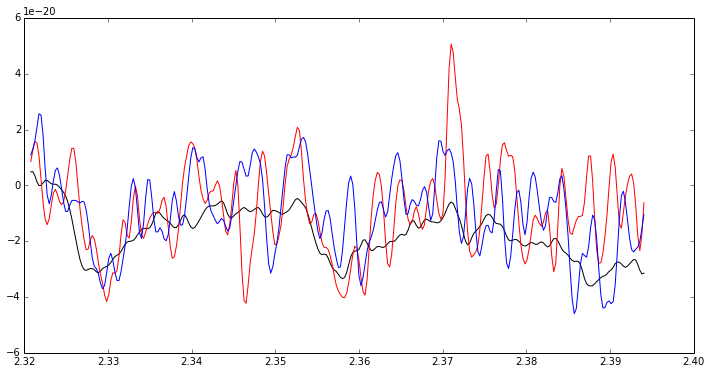

In [72]:
#MAIN

#load the data
f=pyfits.open(in_file)
head=f[0].header
data=f[0].data


copDat = np.zeros([data.shape[0],data.shape[1],data.shape[2]])
copDat[z_low:z_up,y_low:y_up,x_low:x_up]=data[z_low:z_up,y_low:y_up,x_low:x_up]*1.

#hanning
copDat=hanning_mine(copDat,delta_vel)

#median
copDat=median_mine(copDat,z_low,z_up,z_low,z_low+((z_up-z_low)/2.),z_low+((z_up-z_low)/2.),z_up)

#extract the spectra
spec1=np.zeros([data.shape[0]])
for i in xrange (0,data.shape[0]):
    spec1[i]=np.mean(copDat[i,y_dC:y_uC,x_lC:x_rC])

    
spec2=np.zeros([data.shape[0]])
for i in xrange (0,data.shape[0]):
    spec2[i]=np.sum(copDat[i,y_dS:y_uS,x_lS:x_rS])  
    
 
    
spec3=np.zeros([data.shape[0]])
for i in xrange (0,data.shape[0]):
    spec3[i]=np.sum(copDat[i,y_dN:y_uN,x_lN:x_rN])      
    
    
#PLOT
fig = plt.figure(figsize=(12,6))
params = {'legend.fontsize': 14,
           'axes.linewidth':1,
           'lines.linewidth':5,
           'legend.linewidth': 4,
           'xtick.labelsize':22,
           'ytick.labelsize':22,
           'xlabel.fontsize':22,
           'ylabel.fontsize':22,
           'text.usetex': True,
           'text.latex.unicode' : True }
rc('font',**{'family':'serif','serif':['serif']})


a = fig.add_subplot(111, autoscalex_on=True,autoscaley_on=True)
a.plot(wave[z_low_star:z_up_star],spec1[z_low_star:z_up_star],c='black',lw=1,label='centre')
a.plot(wave[z_low_star:z_up_star],spec2[z_low_star:z_up_star],c='red',lw=1,label='centre')
a.plot(wave[z_low_star:z_up_star],spec3[z_low_star:z_up_star],c='blue',lw=1,label='centre')

a.set_xlim=([2.3,2.4])

fig.savefig(out_fig_stars,bbox_inches='tight')


**************
# Fluxes, Luminosities Masses and accretion rates

Extract the flux of the line from a selected region, compute the luminosity and the mass of the gas


Flux : it automatically converts the cubes in $\rm W/cm^2$ into $\rm erg\,s^{-1}\,cm^{-2}$

Luminosity:

$$ L\,= \,4\pi\,D_L^2\, F_{\rm H_2 1-0 S(1)} $$

Mass of the warm gas (Storchi-Bergmann et al. 2009):

$$ M_{\rm H2}^{\rm warm} =  5.0776\times10^{13}\bigg(\frac{F_{\rm H_2 1-0 S(1)}}{\rm erg s^{-1} cm^{-2}}\bigg) \bigg(\frac{D}{\rm Mpc}\bigg)^2 $$

Masses of the cold gas (1,2 - Muller-Sanchez et al. 2006; 3 - Mazzalay et al. 2013):

$$ M_{\rm H2}^{\rm cold} = 4000 \frac{M_\odot}{L_\odot}$$

$$ M_{\rm H2}^{\rm cold} = 1-5 \times 10^6\,\, M_{\rm H2}^{\rm warm} $$

$$ M_{\rm H2}^{\rm cold} = 1174 \frac{M_\odot}{L_\odot}$$

Accretion rate:

- timescale of the accretion given by the velocity of the clouds v and the distance from the nucleus

$$ t_{\rm accretion} = \frac{d}{v} = \frac{150\,{\rm pc}}{100\,{\rm
km\,s^{-1}}}\,\,\,[{\rm years}] $$

- accretion rate:

$$\dot{M}= \frac{M_{\rm gas}}{t_{\rm accretion}}\,\,\,[{\rm M_\odot\, yr^{-1}}] $$

**********

Define the main parameters:

    - Input file: final non hanned cube
    - Output file: text file
    
    - Location of the line
    - Regions of the field of view
        - Centre: C
        - Inner Disk: IN
    - Flux cutoff
    - Normalization factors for readable units
        
    - Constants:
        - luminosity distance
        - dust exctinction for the mass (set to zero,usually)
        
    - Accretion rates:
        - Infall velocity of the cloud
        - Distance of the cloud
        - Mass HI clouds in Solar Masses

In [129]:
#filenames

in_file=root_cube+'nh.fits' 
out_txt=rootdir+'analysis_results.txt'

#region of the field of view

#CENTRE
x_lC=38
x_rC=43
y_dC=38
y_uC=42
#deviating component in the centre in channels
z_lowC=917
z_upC=925

#INNER DISK
x_lIN=19
x_rIN=60
y_dIN=27
y_uIN=50
#location of the line in channels
z_lowIN=900
z_upIN=930


#cutoff

#normalization factors for readable units
norm_flux=1e-13
norm_flux_str=' x 10^-13 '
norm_mass=1e8
norm_mass_str=' x 10^8 '
norm_time=1e6
norm_time_str=' x 10^6 '
norm_accr=1e-2
norm_accr_str=' x 10^-2 '


#Constants
D_L=62.4 #Mpc
LSun= 3.846e33

#Accretion
vel_cloud= 100 #km/s
d_pc = 150 #pc
mHI=1e4



Main of the ANALYSIS

In [128]:
#MAIN
f=pyfits.open(in_file)
infile=f[0].data
head=f[0].header

xlen = infile.shape[2]
ylen = infile.shape[1]
zlen = infile.shape[0]

infilecool=np.zeros([zlen,ylen,xlen])

value=1.51247420e-20
for k in xrange(z_lowC,z_upC):
    for j in xrange(y_dC,y_uC):
        for i in xrange(x_lC,x_rC):
            if infile[k,j,i]>=value:
                infilecool[k,j,i]=infile[k,j,i]


flux_dev= np.sum(infilecool[:,:,:])


file=root_cube+'nh.fits'
f=pyfits.open(file)
infile=f[0].data
head=f[0].header
value=1.7e-20
infilecool=np.zeros([zlen,ylen,xlen])
for k in xrange(z_lowIN,z_upIN):
    for j in xrange(y_dIN,y_uIN):
        for i in xrange(x_lIN,x_rIN):
            if infile[k,j,i]>=value:
                infilecool[k,j,i]=infile[k,j,i]
        
flux_disk=np.sum(infilecool[:,:,:])

#set the right units
flux_disk=np.multiply(flux_disk,(wave[z_upIN]-wave[z_lowIN]))
flux_dev=np.multiply(flux_dev,(wave[z_upC]-wave[z_lowC]))

#### CONVERT TO THE RIGHT UNITS
#from W cm^-2 to erg s^-1 cm^-2: x 1e7 

flux_disk_erg=flux_disk*1e7
flux_dev_erg=flux_dev*1e7

flux_disk_p=round(flux_disk_erg/norm_flux,5)
flux_dev_p=round(flux_dev_erg/norm_flux,5)

print 'Flux INNER DISK'
print str(flux_disk_p)+norm_flux_str+'erg s^-1 cm^-2 \n'
print 'Flux DEVIATING COMPONENT'
print str(flux_dev_p)+norm_flux_str+'erg s^-1 cm^-2 \n'

# FLUX -> LUMINOSITY

lum_disk=flux_disk_erg*4*math.pi*pow(D_L*1e6*3.0857e18 ,2)
lum_dev=flux_dev_erg*4*math.pi*pow(D_L*1e6*3.0857e18 ,2)

print 'Luminosity INNER DISK'
print str(lum_disk)+' erg s^-1 \n'
print 'Luminosity DEVIATING COMPONENT'
print str(lum_dev)+' erg s^-1 \n'


#FLUX -> MASS
#define some constants
K=5.08e13

# the flux in the formula must be in erg/scm2
m_warm_dev=K* (D_L*D_L) * flux_dev_erg
m_warm_disk=K* (D_L*D_L) * flux_disk_erg

print '***** MASS WARM H2 ****'

print 'Mass INNER DISK'
print str(m_warm_disk)+' MSun \n'
print 'Mass DEVIATING COMPONENT'
print str(m_warm_dev)+' MSun \n'

#Luminosity -> MASS


mcold_diskMS=1174*lum_disk/LSun
mcold_devMS=1174*lum_dev/LSun

mcold_diskMSM=1e6*m_warm_disk
mcold_devMSM=1e6*m_warm_dev


mcold_diskM=4000*lum_disk/LSun
mcold_devM=4000*lum_dev/LSun


print '***** MASS COLD H2 ****'
print 'Muller-Sanchez'
print 'Mass cold H2 INNER DISK'
print str(mcold_diskMS/norm_mass)+norm_mass_str+' MSun \n'
print 'Mass cold H2 DEVIATING COMPONENT'
print str(mcold_devMS/norm_mass)+norm_mass_str+' MSun \n'

print 'Muller-Sanchez warm mass'
print 'Mass cold H2 INNER DISK'
print str(mcold_diskMSM/norm_mass)+norm_mass_str+' MSun \n'
print 'Mass cold H2 DEVIATING COMPONENT'
print str(mcold_devMSM/norm_mass)+norm_mass_str+' MSun \n'

print 'Mazzalay'
print 'Mass cold H2 INNER DISK'
print str(mcold_diskM/norm_mass)+norm_mass_str+' MSun \n'
print 'Mass cold H2 DEVIATING COMPONENT'
print str(mcold_devM/norm_mass)+norm_mass_str+' MSun \n'

## ACCRETION RATE
#timescale for the accretion

d_pc=d_pc*PC*1e-5 #d in km

timescale=d_pc/(vel_cloud*3600.*24.*365.) #timescale in years

print '***** ACCRETION RATES *****'
print str(timescale/norm_time)+norm_time_str+' years - timescale \n'

#accretion rate

#warm H2
mass=m_warm_dev

accretion=mass/timescale
print 'WARM H2'
print str(accretion)+' Msun/year - Accretion rate \n'

#warm H2
mass=mcold_devM

accretion=mass/timescale
print 'COLD H2'
print str(accretion)+' Msun/year - Accretion rate \n'

#warm H2
mass=mHI

accretion=mass/timescale
print 'HI'
print str(accretion)+' Msun/year - Accretion rate \n'


Flux INNER DISK
1.5285 x 10^-13 erg s^-1 cm^-2 

Flux DEVIATING COMPONENT
0.00611 x 10^-13 erg s^-1 cm^-2 

Luminosity INNER DISK
7.12120033195e+40 erg s^-1 

Luminosity DEVIATING COMPONENT
2.84600746165e+38 erg s^-1 

***** MASS WARM H2 ****
Mass INNER DISK
30234.2813848 MSun 

Mass DEVIATING COMPONENT
120.832144032 MSun 

***** MASS COLD H2 ****
Muller-Sanchez
Mass cold H2 INNER DISK
217.376213981 x 10^8  MSun 

Mass cold H2 DEVIATING COMPONENT
0.868750067596 x 10^8  MSun 

Muller-Sanchez warm mass
Mass cold H2 INNER DISK
302.342813848 x 10^8  MSun 

Mass cold H2 DEVIATING COMPONENT
1.20832144032 x 10^8  MSun 

Mazzalay
Mass cold H2 INNER DISK
740.634459901 x 10^8  MSun 

Mass cold H2 DEVIATING COMPONENT
2.95996615876 x 10^8  MSun 

***** ACCRETION RATES *****
1.46770357686 x 10^6  years - timescale 

WARM H2
8.2327348612e-05 Msun/year - Accretion rate 

COLD H2
201.673294623 Msun/year - Accretion rate 

HI
0.00681336487669 Msun/year - Accretion rate 

